<a href="https://colab.research.google.com/github/vs-06/Project_C-Refocus/blob/main/MSDS_Project_Team3_CLIP_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets pillow torch transformers



## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/flickr30k_data"
os.makedirs(DATA_DIR, exist_ok=True)

print("Dataset folder ready:", DATA_DIR)


Dataset folder ready: /content/drive/MyDrive/flickr30k_data


In [ ]:
from datasets import load_dataset

ds = load_dataset(
    "AnyModal/flickr30k",
    split="train",
    cache_dir=DATA_DIR
)

print("Dataset loaded and cached.")




Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset loaded and cached.


In [ ]:
ds.save_to_disk(DATA_DIR + "/arrow_dataset")


Saving the dataset (0/9 shards):   0%|          | 0/29000 [00:00<?, ? examples/s]

## FUTURE DATA LOADS:


In [ ]:
from datasets import load_from_disk
ds = load_from_disk(DATA_DIR + "/arrow_dataset")

In [ ]:
ex = ds[0]
for k, v in ex.items():
    if isinstance(v, str):
        print("string field:", k)
    if isinstance(v, list) and len(v) > 0 and isinstance(v[0], str):
        print("list-of-strings field:", k, "len:", len(v))


list-of-strings field: alt_text len: 1
list-of-strings field: sentids len: 5
string field: split
string field: img_id
string field: filename
list-of-strings field: original_alt_text len: 5


## Step 6: Choosing the text field

In [ ]:
CAPTION_KEY = "original_alt_text"

ex = ds[0]
print("Example captions:")
for i, c in enumerate(ex[CAPTION_KEY]):
    print(i, c)


Example captions:
0 Two young guys with shaggy hair look at their hands while hanging out in the yard.
1 Two young, White males are outside near many bushes.
2 Two men in green shirts are standing in a yard.
3 A man in a blue shirt standing in a garden.
4 Two friends enjoy time spent together.


## Creating Labelled Pairs (Positive + Negative)

In [ ]:
import random

CAPTION_KEY = "original_alt_text"
random.seed(42)

def make_pair(idx):
    ex = ds[idx]
    image = ex["image"]
    pos_text = random.choice(ex[CAPTION_KEY])

    # Pick a different image for the negative caption
    neg_idx = random.randrange(len(ds))
    while neg_idx == idx:
        neg_idx = random.randrange(len(ds))

    neg_text = random.choice(ds[neg_idx][CAPTION_KEY])

    return (image, pos_text, 1), (image, neg_text, 0)

pos, neg = make_pair(0)
print("POS:", pos[1], "label:", pos[2])
print("NEG:", neg[1], "label:", neg[2])



POS: Two young guys with shaggy hair look at their hands while hanging out in the yard. label: 1
NEG: Four young boys are running down a sidewalk. label: 0


## Step 8: Build a small Labelled Dataset pairs (image, text, label) pairs we can feed in to the CLIP later.

In [ ]:
import random

CAPTION_KEY = "original_alt_text"
random.seed(42)

def make_pair(idx):
    ex = ds[idx]
    image = ex["image"]
    pos_text = random.choice(ex[CAPTION_KEY])

    # negative caption from a different image
    neg_idx = random.randrange(len(ds))
    while neg_idx == idx:
        neg_idx = random.randrange(len(ds))
    neg_text = random.choice(ds[neg_idx][CAPTION_KEY])

    return (image, pos_text, 1), (image, neg_text, 0)

# Build N images -> 2N pairs (1 pos + 1 neg each)
N_IMAGES = 2000  # keep small for now
pairs = []
for idx in range(N_IMAGES):
    pos, neg = make_pair(idx)
    pairs.append(pos)
    pairs.append(neg)

random.shuffle(pairs)

print("Total pairs:", len(pairs))
print("Example:", pairs[0][1], "label:", pairs[0][2])


Total pairs: 4000
Example: The guard is looking at the city past the wall. label: 0


# Displaying Sample images with positive and negative captions.

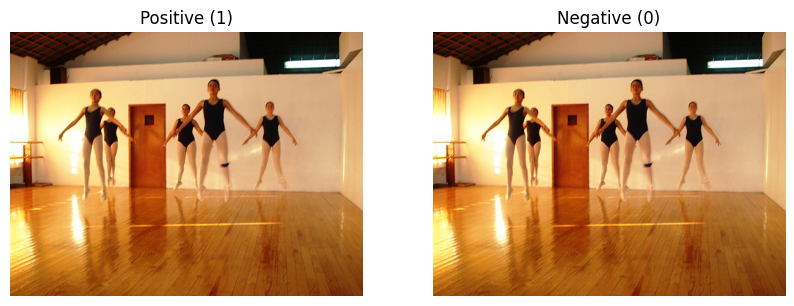

Positive caption: Ballet dancers in a studio practice jumping with wonderful form.
Negative caption: A man is doing a handstand in a park on a sunny day.


In [ ]:
import matplotlib.pyplot as plt

def compare_pos_neg(pos, neg):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(pos[0])
    axes[0].set_title("Positive (1)")
    axes[0].axis("off")

    axes[1].imshow(neg[0])
    axes[1].set_title("Negative (0)")
    axes[1].axis("off")

    plt.show()

    print("Positive caption:", pos[1])
    print("Negative caption:", neg[1])

# Example
pos, neg = make_pair(10)
compare_pos_neg(pos, neg)


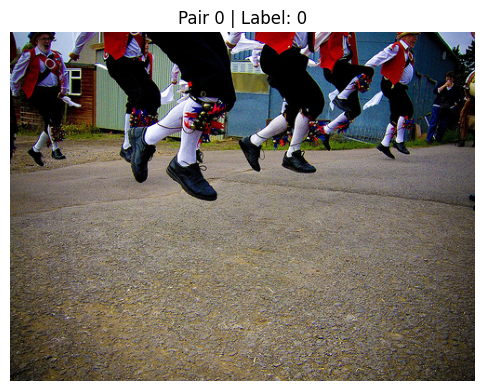

Caption:
The guard is looking at the city past the wall.
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size: (500, 375)


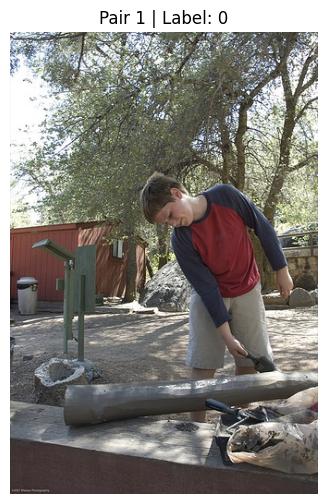

Caption:
A boy looking at something purple in another boy's hair.
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size: (333, 500)


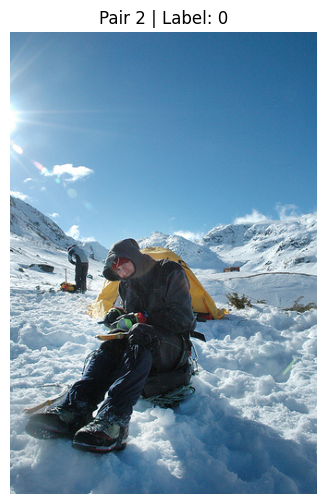

Caption:
A woman reading a children's book.
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size: (332, 500)


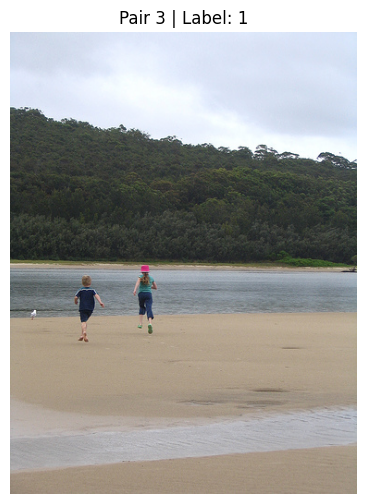

Caption:
Two little kids are running through the sand to get to the ocean.
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size: (375, 500)


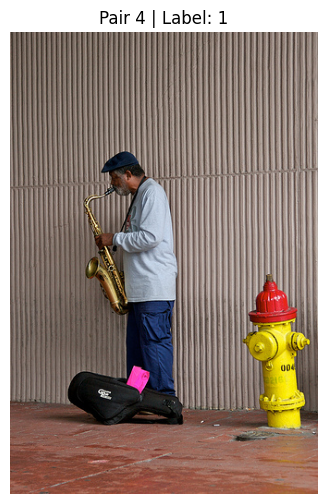

Caption:
A man is playing a saxophone next to a fire hydrant.
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size: (333, 500)


In [ ]:
import matplotlib.pyplot as plt

def inspect_raw_pairs(pairs, n=5):
    for i in range(n):
        image, text, label = pairs[i]

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Pair {i} | Label: {label}")
        plt.show()

        print("Caption:")
        print(text)
        print("Image type:", type(image))
        print("Image size:", image.size)
        print("=" * 80)

inspect_raw_pairs(pairs)


## Running ONE pair through CLIP and computing Euclidian Distance

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

@torch.no_grad()
def get_embeddings(image, text):
    inputs = clip_processor(
        images=image,
        text=[text],
        return_tensors="pt",
        padding=True
    ).to(DEVICE)

    outputs = clip_model(**inputs)  # forward pass through both encoders

    # These are tensors of shape (batch, embed_dim)
    v_img = outputs.image_embeds[0]  # shape (512,)
    v_txt = outputs.text_embeds[0]   # shape (512,)

    return v_img, v_txt

def l2_distance(v1, v2):
    return torch.norm(v1 - v2, p=2).item()

pos_sample = next(s for s in pairs if s[2] == 1)
neg_sample = next(s for s in pairs if s[2] == 0)

vimg_pos, vtxt_pos = get_embeddings(pos_sample[0], pos_sample[1])
vimg_neg, vtxt_neg = get_embeddings(neg_sample[0], neg_sample[1])

print("Positive label=1 L2 distance:", l2_distance(vimg_pos, vtxt_pos))
print("Negative label=0 L2 distance:", l2_distance(vimg_neg, vtxt_neg))
print("Embedding dim:", vimg_pos.shape)


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Positive label=1 L2 distance: 1.2046900987625122
Negative label=0 L2 distance: 1.2679765224456787
Embedding dim: torch.Size([512])


## Step 10: Computing Distances for 200 Positives and 200 Negatives

In [ ]:
import random
import numpy as np
import torch

def sample_by_label(pairs, label, k):
    subset = [p for p in pairs if p[2] == label]
    return random.sample(subset, k)

@torch.no_grad()
def compute_l2_for_samples(samples):
    dists = []
    for image, text, label in samples:
        v_img, v_txt = get_embeddings(image, text)
        dists.append(l2_distance(v_img, v_txt))
    return np.array(dists)

random.seed(42)

K = 200
pos_samples = sample_by_label(pairs, 1, K)
neg_samples = sample_by_label(pairs, 0, K)

pos_d = compute_l2_for_samples(pos_samples)
neg_d = compute_l2_for_samples(neg_samples)

print("POS mean/std:", pos_d.mean(), pos_d.std())
print("NEG mean/std:", neg_d.mean(), neg_d.std())
print("POS median:", np.median(pos_d))
print("NEG median:", np.median(neg_d))
print("Fraction where POS < NEG (pairwise by index):", np.mean(pos_d < neg_d))


POS mean/std: 1.1691955471038817 0.02948910614890765
NEG mean/std: 1.2865493059158326 0.03282564314215383
POS median: 1.1689873933792114
NEG median: 1.2893555760383606
Fraction where POS < NEG (pairwise by index): 1.0
